## Notebook for semantic segmentation of land cover
- Use (12.5cm currently) aerial images (3 bands)
- Use raster masks with class labels
- Use U-net (like) CNN to perform semantic segmentation. 

Thoughts:
- Handle no-class? (class = 0). Could fix in data by interpolating - although that takes some time.. Can we somehow set the cost to 0 of these pixels? Don't want to ruin the conv filters. 
- Possibly change class labels here. (Eg wood vs grass vs other). Probably best to do here when loading raster masks, instead of creating masks like this directly (as they take up considerable disk space and there might be many version. Should be quick to do.)

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import torch, torchvision
import segmentation_models_pytorch as smp

### Split image into patches:

In [3]:
all_patches_img, all_patches_mask = lca.create_all_patches_from_dir(patch_size=500)

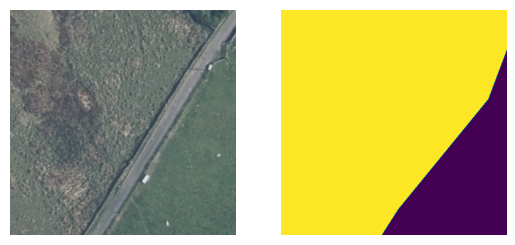

In [4]:
fig, ax = plt.subplots(1, 2)
i_p = 0  # index of patch. Left to righ, top to bottom 
lcv.plot_image_simple(im=all_patches_img[i_p, :, :, :], ax=ax[0])

ax[1].imshow(all_patches_mask[i_p, :, :])
lcv.naked(ax[1])

### Create train/test split
- Random split for now. 
- Later look into way to split classes evenly across train and test set. 

In [5]:
im_train, im_test, mask_train, mask_test = lca.split_patches_in_train_test(all_patches_img=all_patches_img, all_patches_mask=all_patches_mask)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


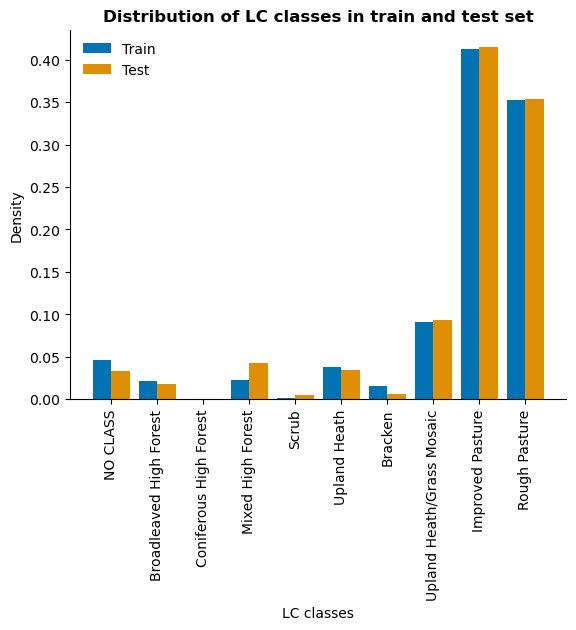

In [6]:
lcv.plot_comparison_class_balance_train_test(train_patches_mask=mask_train, test_patches_mask=mask_test)

### Fetch CNN model:
- Resource 1: UNet (https://github.com/milesial/Pytorch-UNet)
- Resource 2: Pytorch pretrained (only Resnet): https://pytorch.org/vision/stable/models.html and https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- Resource 3: SM pretrained: https://github.com/qubvel/segmentation_models.pytorch


### Prep
- See if GPU works:

In [9]:
assert torch.cuda.is_available()
print(f'Pytorch version is {torch.__version__}')
print(f'Torchvision version is {torchvision.__version__}')
print(f'Segmentation-models-pytorch version is {smp.__version__}')

Pytorch version is 1.12.1+cu102
Torchvision version is 0.13.1+cu102
Segmentation-models-pytorch version is 0.3.0


### Resource 1:

In [13]:
unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

Using cache found in /home/tplas/.cache/torch/hub/milesial_Pytorch-UNet_master


### Resource 2:


In [12]:
resnet = torchvision.models.resnet50(weights='IMAGENET1K_V2')  # use pretrained weights, see docs

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/tplas/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
res_weights = resnet.parameters

In [14]:
res_weights.transforms()

AttributeError: 'function' object has no attribute 'transforms'